Average color of reference image (RGB): [140.20284986 142.45219899 166.95971557]
Average color of corrected image (RGB): [121.52915519 148.25078972 168.95537879]
Average color of warm corrected image (RGB): [122.52915519 147.25078972 167.95537879]
Total Brightness Adjustment: 0.09913313388824463
Total Contrast Adjustment: -0.04115906357765198
Total Color Difference: 0.006878165528178215
Total RGB Changes (R, G, B): [ 6380.808   -1956.767    -656.82416]


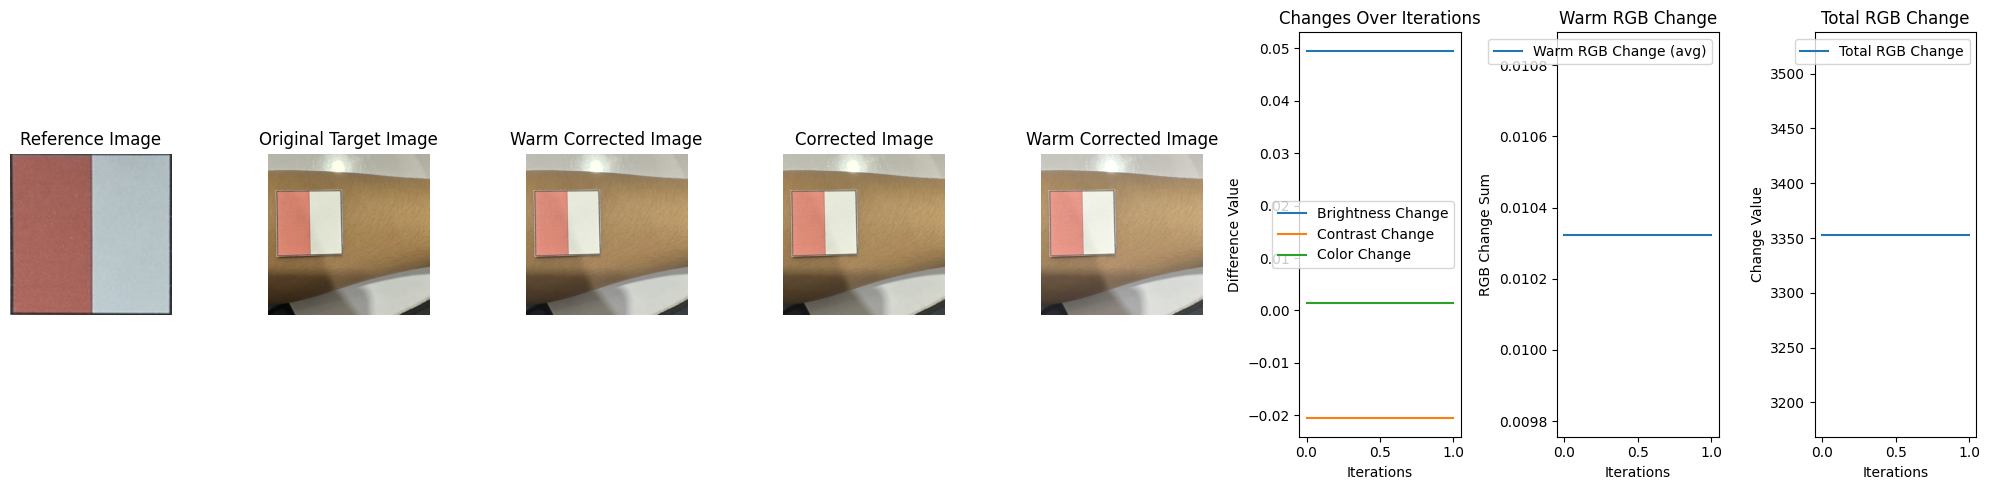

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_colors(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not loaded correctly.")
        return None, None

    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'Red': [(0, 100, 100), (10, 255, 255)],
        'Red2': [(160, 100, 100), (180, 255, 255)],
        'White': [(0, 0, 180), (180, 50, 255)]
    }

    combined_bbox = None
    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                x, y, w, h = cv2.boundingRect(cnt)
                if combined_bbox is None:
                    combined_bbox = (x, y, x + w, y + h)
                else:
                    combined_bbox = (
                        min(combined_bbox[0], x),
                        min(combined_bbox[1], y),
                        max(combined_bbox[2], x + w),
                        max(combined_bbox[3], y + h)
                    )

    if combined_bbox:
        x1, y1, x2, y2 = combined_bbox
        cropped_img = image[y1:y2, x1:x2]
        return cropped_img, (x1, y1, x2, y2)
    else:
        print("No valid colors detected!")
        return None, None

def adjust_brightness_contrast(reference_img, target_img):
    ref = reference_img.astype(np.float32) / 255.0
    target = target_img.astype(np.float32) / 255.0
    ref_avg_brightness = np.mean(ref)
    target_avg_brightness = np.mean(target)

    brightness_diff = ref_avg_brightness - target_avg_brightness
    contrast_diff = np.std(ref) - np.std(target)
    
    adjusted_target = target.copy()

    adjusted_target += brightness_diff
    adjusted_target = (adjusted_target - 0.001) * (1 + contrast_diff) + 0.001
    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    corrected_img = (adjusted_target * 255).astype(np.uint8)
    return corrected_img, brightness_diff, contrast_diff

def adjust_tone(reference_img, target_img, step=0.0001):
    reference_img = reference_img.astype(np.float32) / 255.0
    target_img = target_img.astype(np.float32) / 255.0
    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    target_avg_color = np.mean(target_img, axis=(0, 1))

    color_diff = ref_avg_color - target_avg_color

    # Scale the color difference to avoid overcorrection
    scale_factor = 0.1  # Adjust this as needed
    color_diff *= scale_factor

    adjusted_target = target_img.copy()
    adjusted_target += color_diff  # Directly add the difference

    # Track the change in each channel (RGB) per pixel
    rgb_changes = adjusted_target - target_img  # per-pixel RGB changes

    adjusted_target[:, :, 0] *= (1 + color_diff[0] * step)
    adjusted_target[:, :, 1] *= (1 + color_diff[1] * step)
    adjusted_target[:, :, 2] *= (1 + color_diff[2] * step)

    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    # Sum the total RGB changes for all pixels (per channel)
    total_rgb_changes = np.sum(rgb_changes, axis=(0, 1))  # Sum per channel (R, G, B)
    
    return (adjusted_target * 255).astype(np.uint8), color_diff, rgb_changes, total_rgb_changes

def calculate_color_difference(reference_img, corrected_img):
    color_diff = np.abs(reference_img.astype(np.float32) - corrected_img.astype(np.float32))
    return color_diff

def apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff):
    # แปลงภาพเป็น float32 เพื่อการคำนวณที่แม่นยำ
    target_img = target_img.astype(np.float32) / 255.0

    # ปรับค่าความสว่าง
    target_img += brightness_diff

    # ปรับคอนทราสต์
    target_img = (target_img - 0.5) * (1 + contrast_diff) + 0.5

    # ปรับโทนสี (R, G, B)
    target_img[:, :, 0] += color_diff[0]
    target_img[:, :, 1] += color_diff[1]
    target_img[:, :, 2] += color_diff[2]

    # คำนวณภาพสุดท้ายหลังการปรับ
    target_img = np.clip(target_img, 0, 1)

    # แปลงกลับเป็น uint8 และ return
    return (target_img * 255).astype(np.uint8)

# ในส่วนของฟังก์ชัน main
def main():
    reference_img = cv2.imread('wtest2.jpg')  # Reference image
    target_img = cv2.imread('wtest7.jpg')  # Target image for analysis
    cropped_img, bbox = detect_colors('wtest7.jpg')

    target_img_as = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

    if cropped_img is None or bbox is None:
        return

    x1, y1, x2, y2 = bbox
    if reference_img is None or target_img is None:
        print("Error: Unable to load images")
        return

    cropped_img_resized = cv2.resize(cropped_img, (x2 - x1, y2 - y1))  # แก้ให้ตรงกับขนาดจริง

    target_img = cv2.resize(target_img, (reference_img.shape[1], reference_img.shape[0]))

    previous_avg_diff = np.inf  # Start with the highest possible difference
    tolerance = 0.01  # Acceptable difference tolerance

    # Track changes in brightness, contrast, color, and warm color
    brightness_changes = []
    contrast_changes = []
    color_changes = []
    warm_color_changes = []  # Track RGB changes for warm adjustment
    total_rgb_changes_overall = []  # Track total RGB changes for each iteration

    total_brightness_change = 0
    total_contrast_change = 0
    total_color_change = 0

    cropped_img_resized = cv2.resize(cropped_img, (x2 - x1, y2 - y1))  # Resizing to match the crop size
    corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
    warm_corrected_img, color_diff, warm_rgb_changes, total_rgb_changes = adjust_tone(reference_img, corrected_img, step=0.00001)


    while True:
        corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
        warm_corrected_img, color_diff, warm_rgb_changes, total_rgb_changes = adjust_tone(reference_img, corrected_img, step=0.00001)

        # Collect the changes
        brightness_changes.append(brightness_diff)
        contrast_changes.append(contrast_diff)
        color_changes.append(color_diff)
        warm_color_changes.append(np.mean(np.abs(warm_rgb_changes), axis=(0, 1)))  # Track average RGB change for warm
        total_rgb_changes_overall.append(total_rgb_changes)  # Track total RGB changes

        total_brightness_change += brightness_diff
        total_contrast_change += contrast_diff
        total_color_change += np.mean(np.abs(color_diff))  # Average color difference

        corrected_avg_color = np.mean(corrected_img, axis=(0, 1))
        warm_corrected_avg_color = np.mean(warm_corrected_img, axis=(0, 1))
        current_avg_diff = np.abs(np.mean(reference_img, axis=(0, 1)) - corrected_avg_color).sum()
        warm_corrected_img_resized = cv2.resize(warm_corrected_img, (x2 - x1, y2 - y1))
        full_img_corrected = apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff)
        
        if current_avg_diff < tolerance:
            break

        target_img = warm_corrected_img

        if abs(previous_avg_diff - current_avg_diff) < tolerance:
            break
        previous_avg_diff = current_avg_diff
    
    target_img[y1:y2, x1:x2] = warm_corrected_img_resized

    # Show results
    reference_img_rgb = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    target_img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    corrected_img_rgb = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB)
    warm_corrected_img_rgb = cv2.cvtColor(warm_corrected_img, cv2.COLOR_BGR2RGB)
    full_img_corrected_rgb = cv2.cvtColor(full_img_corrected, cv2.COLOR_BGR2RGB)

    # Plot the changes
    fig, axes = plt.subplots(1, 8, figsize=(20, 5))  # Increase the number of columns to 8
    axes[0].imshow(reference_img_rgb)
    axes[0].set_title("Reference Image")
    axes[0].axis("off")

    axes[1].imshow(target_img_as)
    axes[1].set_title("Original Target Image")
    axes[1].axis("off")

    axes[2].imshow(warm_corrected_img_rgb)
    axes[2].set_title("Warm Corrected Image")
    axes[2].axis("off")

    axes[3].imshow(corrected_img_rgb)
    axes[3].set_title("Corrected Image")
    axes[3].axis("off")

    axes[4].imshow(full_img_corrected_rgb)
    axes[4].set_title("Warm Corrected Image")
    axes[4].axis("off")

    # Plotting the changes
    axes[5].plot(brightness_changes, label="Brightness Change")
    axes[5].plot(contrast_changes, label="Contrast Change")
    axes[5].plot([np.mean(diff) for diff in color_changes], label="Color Change")
    axes[5].set_title("Changes Over Iterations")
    axes[5].set_xlabel("Iterations")
    axes[5].set_ylabel("Difference Value")
    axes[5].legend()

    axes[6].plot([change.sum() for change in warm_color_changes], label="Warm RGB Change (avg)")
    axes[6].set_title("Warm RGB Change")
    axes[6].set_xlabel("Iterations")
    axes[6].set_ylabel("RGB Change Sum")
    axes[6].legend()

    # Plot the total RGB changes per iteration
    axes[7].plot([np.linalg.norm(change) for change in total_rgb_changes_overall], label="Total RGB Change")
    axes[7].set_title("Total RGB Change")
    axes[7].set_xlabel("Iterations")
    axes[7].set_ylabel("Change Value")
    axes[7].legend()

    # Print average colors
    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    corrected_avg_color = np.mean(corrected_img, axis=(0, 1))
    warm_corrected_avg_color = np.mean(warm_corrected_img, axis=(0, 1))

    print(f"Average color of reference image (RGB): {ref_avg_color}")
    print(f"Average color of corrected image (RGB): {corrected_avg_color}")
    print(f"Average color of warm corrected image (RGB): {warm_corrected_avg_color}")

    # Display total changes
    print(f"Total Brightness Adjustment: {total_brightness_change}")
    print(f"Total Contrast Adjustment: {total_contrast_change}")
    print(f"Total Color Difference: {total_color_change}")
    
    # Print total RGB changes (summed for all iterations)
    total_rgb_change = np.sum(total_rgb_changes_overall, axis=0)  # Sum total RGB changes
    print(f"Total RGB Changes (R, G, B): {total_rgb_change}")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

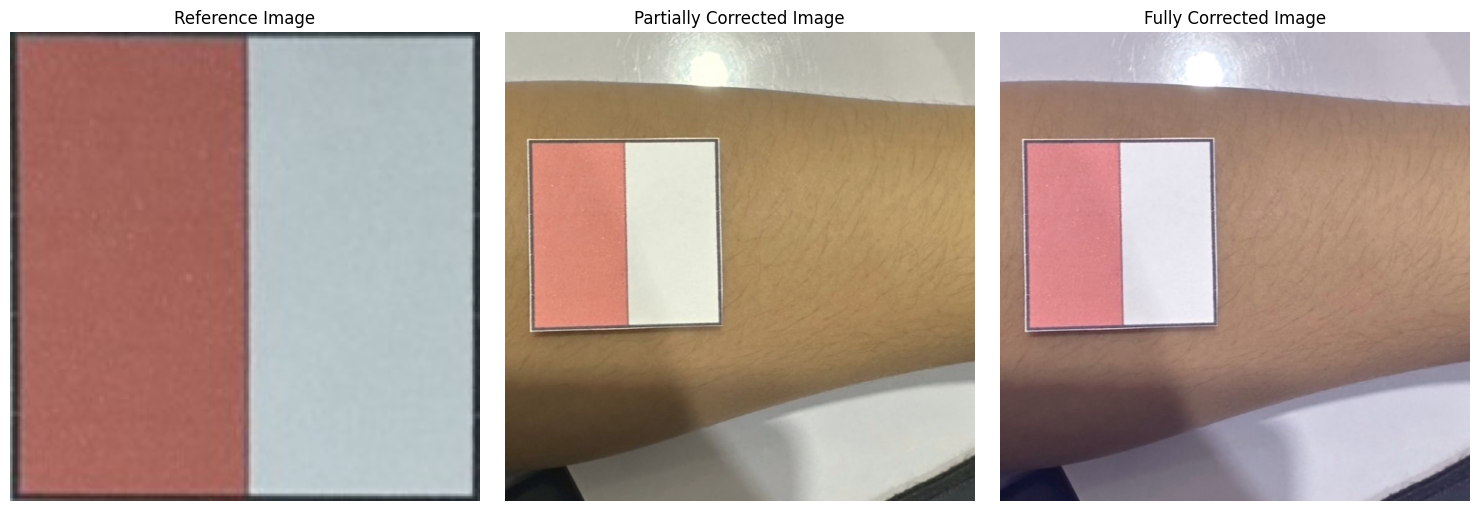

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_colors(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not loaded correctly.")
        return None, None

    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'Red': [(0, 100, 100), (10, 255, 255)],
        'Red2': [(160, 100, 100), (180, 255, 255)],
        'White': [(0, 0, 180), (180, 50, 255)]
    }

    combined_bbox = None
    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                x, y, w, h = cv2.boundingRect(cnt)
                if combined_bbox is None:
                    combined_bbox = (x, y, x + w, y + h)
                else:
                    combined_bbox = (
                        min(combined_bbox[0], x),
                        min(combined_bbox[1], y),
                        max(combined_bbox[2], x + w),
                        max(combined_bbox[3], y + h)
                    )

    if combined_bbox:
        x1, y1, x2, y2 = combined_bbox
        cropped_img = image[y1:y2, x1:x2]
        return cropped_img, (x1, y1, x2, y2)
    else:
        print("No valid colors detected!")
        return None, None

def adjust_brightness_contrast(reference_img, target_img):
    ref = reference_img.astype(np.float32) / 255.0
    target = target_img.astype(np.float32) / 255.0
    brightness_diff = np.mean(ref) - np.mean(target)
    contrast_diff = np.std(ref) - np.std(target)

    adjusted_target = target.copy()
    adjusted_target += brightness_diff
    adjusted_target = (adjusted_target - 0.001) * (1 + contrast_diff) + 0.001
    adjusted_target = np.clip(adjusted_target, 0, 1)

    return (adjusted_target * 255).astype(np.uint8), brightness_diff, contrast_diff

def adjust_tone(reference_img, target_img, step=0.0001):
    reference_img = reference_img.astype(np.float32) / 255.0
    target_img = target_img.astype(np.float32) / 255.0
    color_diff = np.mean(reference_img, axis=(0, 1)) - np.mean(target_img, axis=(0, 1))

    adjusted_target = target_img.copy()
    adjusted_target[:, :, 0] *= (1 + color_diff[0] * step)
    adjusted_target[:, :, 1] *= (1 + color_diff[1] * step)
    adjusted_target[:, :, 2] *= (1 + color_diff[2] * step)
    adjusted_target = np.clip(adjusted_target, 0, 1)

    return (adjusted_target * 255).astype(np.uint8), color_diff

def apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff):
    target_img = target_img.astype(np.float32) / 255.0
    target_img += brightness_diff
    target_img = (target_img - 0.5) * (1 + contrast_diff) + 0.5
    target_img[:, :, 0] += color_diff[0]
    target_img[:, :, 1] += color_diff[1]
    target_img[:, :, 2] += color_diff[2]
    target_img = np.clip(target_img, 0, 1)
    return (target_img * 255).astype(np.uint8)

def main():
    reference_img = cv2.imread('wtest2.jpg')
    target_img = cv2.imread('wtest7.jpg')

    cropped_img, bbox = detect_colors('wtest7.jpg')
    
    if cropped_img is None or bbox is None:
        return

    x1, y1, x2, y2 = bbox
    if reference_img is None or target_img is None:
        print("Error: Unable to load images")
        return

    cropped_img_resized = cv2.resize(cropped_img, (x2 - x1, y2 - y1))  # Resizing to match the crop size
    corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
    warm_corrected_img, color_diff = adjust_tone(reference_img, corrected_img, step=0.00001)

    # Loop until the differences are minimized
    threshold = 0.01
    prev_diff = float('inf')
    while True:
        # Perform adjustments
        corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
        warm_corrected_img, color_diff = adjust_tone(reference_img, corrected_img, step=0.00001)

        # Calculate the total difference
        total_diff = np.abs(brightness_diff) + np.abs(contrast_diff) + np.sum(np.abs(color_diff))

        # Break if the difference is below the threshold
        if total_diff < threshold or abs(total_diff - prev_diff) < threshold:
            break

        prev_diff = total_diff

    warm_corrected_img_resized = cv2.resize(warm_corrected_img, (x2 - x1, y2 - y1))

    # Update full image with the corrected values
    full_img_corrected = apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff)

    # Update the cropped part of the image
    target_img[y1:y2, x1:x2] = warm_corrected_img_resized

    reference_img_rgb = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    full_img_corrected_rgb = cv2.cvtColor(full_img_corrected, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(reference_img_rgb)
    axes[0].set_title("Reference Image")
    axes[0].axis("off")

    axes[1].imshow(img_rgb)
    axes[1].set_title("Partially Corrected Image")
    axes[1].axis("off")

    axes[2].imshow(full_img_corrected_rgb)
    axes[2].set_title("Fully Corrected Image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


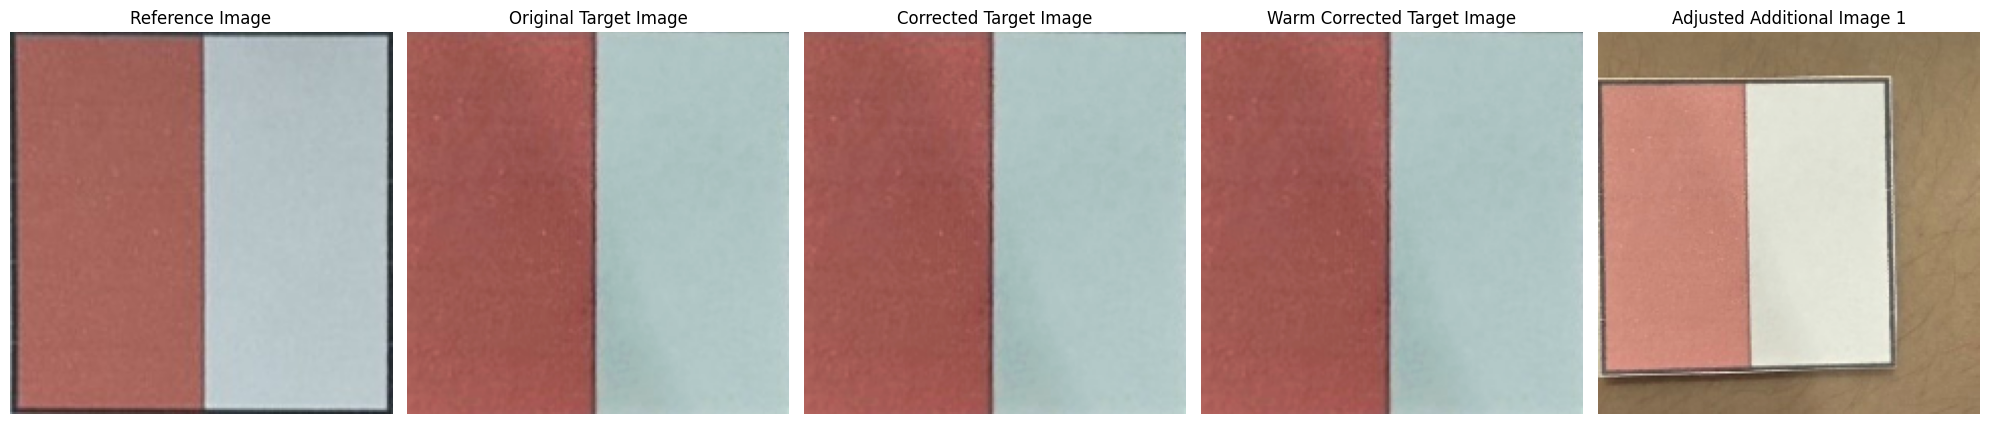

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adjust_brightness_contrast(reference_img, target_img):
    ref = reference_img.astype(np.float32) / 255.0
    target = target_img.astype(np.float32) / 255.0
    ref_avg_brightness = np.mean(ref)
    target_avg_brightness = np.mean(target)

    brightness_diff = ref_avg_brightness - target_avg_brightness
    contrast_diff = np.std(ref) - np.std(target)
    
    adjusted_target = target.copy()

    adjusted_target += brightness_diff
    adjusted_target = (adjusted_target - 0.001) * (1 + contrast_diff) + 0.001
    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    corrected_img = (adjusted_target * 255).astype(np.uint8)
    return corrected_img, brightness_diff, contrast_diff

def adjust_tone(reference_img, target_img, step=0.0001):
    reference_img = reference_img.astype(np.float32) / 255.0
    target_img = target_img.astype(np.float32) / 255.0
    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    target_avg_color = np.mean(target_img, axis=(0, 1))

    color_diff = ref_avg_color - target_avg_color
    scale_factor = 0.1  
    color_diff *= scale_factor

    adjusted_target = target_img.copy()
    adjusted_target += color_diff  
    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    return (adjusted_target * 255).astype(np.uint8), color_diff

def apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff):
    target_img = target_img.astype(np.float32) / 255.0
    target_img += brightness_diff
    target_img = (target_img - 0.5) * (1 + contrast_diff) + 0.5
    target_img[:, :, 0] += color_diff[0]
    target_img[:, :, 1] += color_diff[1]
    target_img[:, :, 2] += color_diff[2]
    target_img = np.clip(target_img, 0, 1)
    return (target_img * 255).astype(np.uint8)

def main():
    reference_img = cv2.imread('wtest2.jpg')
    target_img = cv2.imread('wtest5.jpg')
    target_img_as = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    additional_images = [
        cv2.imread('wtest4.jpg')
    ]

    if reference_img is None or target_img is None or any(img is None for img in additional_images):
        print("Error: Unable to load images")
        return

    target_img = cv2.resize(target_img, (reference_img.shape[1], reference_img.shape[0]))
    additional_images = [cv2.resize(img, (reference_img.shape[1], reference_img.shape[0])) for img in additional_images]

    previous_avg_diff = np.inf
    tolerance = 0.01  

    while True:
        corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, target_img)
        warm_corrected_img, color_diff = adjust_tone(reference_img, corrected_img)

        current_avg_diff = np.abs(np.mean(reference_img, axis=(0, 1)) - np.mean(corrected_img, axis=(0, 1))).sum()

        if current_avg_diff < tolerance:
            break

        target_img = warm_corrected_img

        if abs(previous_avg_diff - current_avg_diff) < tolerance:
            break
        previous_avg_diff = current_avg_diff

    # ใช้ค่าการเปลี่ยนแปลงกับ Additional Images
    adjusted_additional_images = [apply_adjustments(img, brightness_diff, contrast_diff, color_diff) for img in additional_images]

    reference_img_rgb = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    target_img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    corrected_img_rgb = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB)
    warm_corrected_img_rgb = cv2.cvtColor(warm_corrected_img, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].imshow(reference_img_rgb)
    axes[0].set_title("Reference Image")
    axes[0].axis("off")

    axes[1].imshow(target_img_rgb)
    axes[1].set_title("Original Target Image")
    axes[1].axis("off")

    axes[2].imshow(corrected_img_rgb)
    axes[2].set_title("Corrected Target Image")
    axes[2].axis("off")

    axes[3].imshow(warm_corrected_img_rgb)
    axes[3].set_title("Warm Corrected Target Image")
    axes[3].axis("off")

    axes[4].imshow(cv2.cvtColor(adjusted_additional_images[0], cv2.COLOR_BGR2RGB))
    axes[4].set_title("Adjusted Additional Image 1")
    axes[4].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Average color of reference image (RGB): [140.20284986 142.45219899 166.95971557]
Average color of corrected image (RGB): [138.86570925 142.31664847 166.29817194]
Average color of warm corrected image (RGB): [138.86570925 142.31664847 166.29817194]
Total Brightness Adjustment: -0.10419607162475586
Total Contrast Adjustment: 0.12177522480487823
Total Color Difference: 0.044610670185647905
Total RGB Changes (R, G, B): [ 2262.2979     -40.592285 -2345.4353  ]


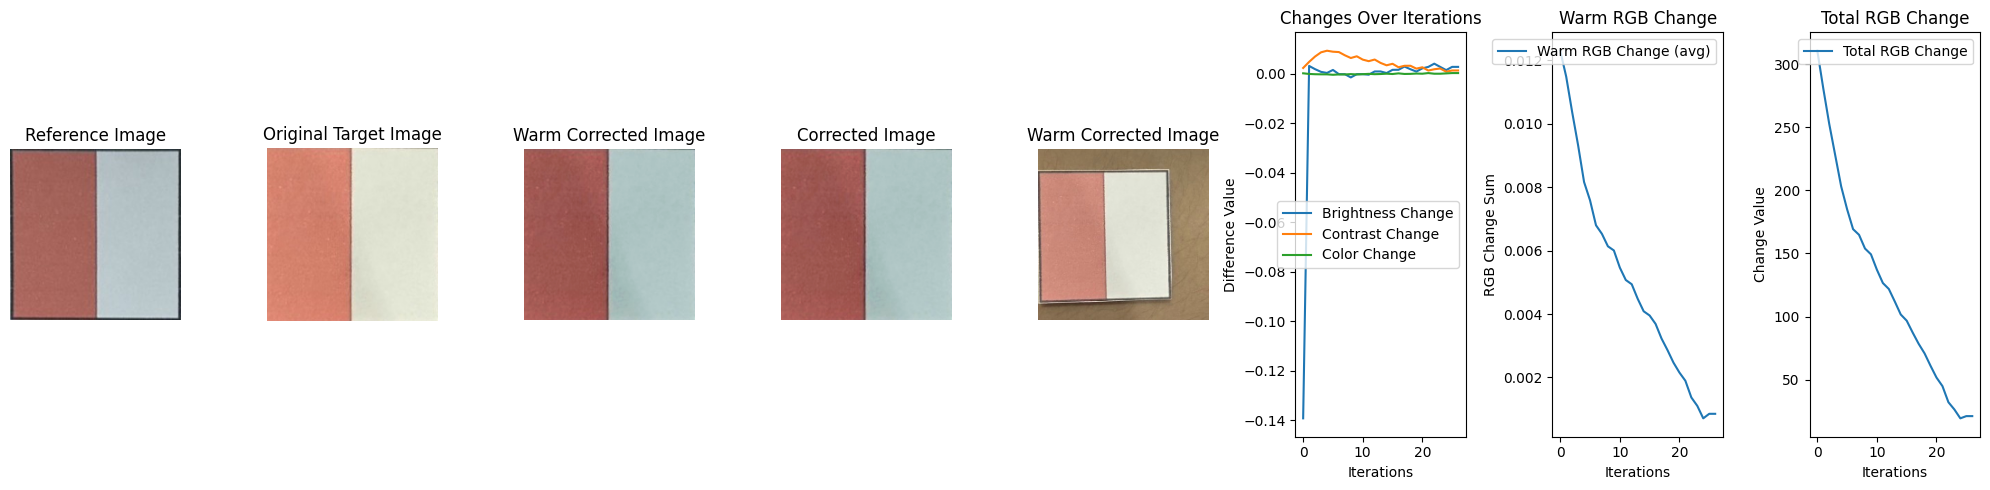

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adjust_brightness_contrast(reference_img, target_img):
    ref = reference_img.astype(np.float32) / 255.0
    target = target_img.astype(np.float32) / 255.0
    ref_avg_brightness = np.mean(ref)
    target_avg_brightness = np.mean(target)

    brightness_diff = ref_avg_brightness - target_avg_brightness
    contrast_diff = np.std(ref) - np.std(target)
    
    adjusted_target = target.copy()

    adjusted_target += brightness_diff
    adjusted_target = (adjusted_target - 0.001) * (1 + contrast_diff) + 0.001
    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    corrected_img = (adjusted_target * 255).astype(np.uint8)
    return corrected_img, brightness_diff, contrast_diff

def adjust_tone(reference_img, target_img, step=0.0001):
    reference_img = reference_img.astype(np.float32) / 255.0
    target_img = target_img.astype(np.float32) / 255.0
    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    target_avg_color = np.mean(target_img, axis=(0, 1))

    color_diff = ref_avg_color - target_avg_color

    # Scale the color difference to avoid overcorrection
    scale_factor = 0.1  # Adjust this as needed
    color_diff *= scale_factor

    adjusted_target = target_img.copy()
    adjusted_target += color_diff  # Directly add the difference

    # Track the change in each channel (RGB) per pixel
    rgb_changes = adjusted_target - target_img  # per-pixel RGB changes

    adjusted_target[:, :, 0] *= (1 + color_diff[0] * step)
    adjusted_target[:, :, 1] *= (1 + color_diff[1] * step)
    adjusted_target[:, :, 2] *= (1 + color_diff[2] * step)

    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    # Sum the total RGB changes for all pixels (per channel)
    total_rgb_changes = np.sum(rgb_changes, axis=(0, 1))  # Sum per channel (R, G, B)
    
    return (adjusted_target * 255).astype(np.uint8), color_diff, rgb_changes, total_rgb_changes

def calculate_color_difference(reference_img, corrected_img):
    color_diff = np.abs(reference_img.astype(np.float32) - corrected_img.astype(np.float32))
    return color_diff

def apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff):
    # แปลงภาพเป็น float32 เพื่อการคำนวณที่แม่นยำ
    target_img = target_img.astype(np.float32) / 255.0

    # ปรับค่าความสว่าง
    target_img += brightness_diff

    # ปรับคอนทราสต์
    target_img = (target_img - 0.5) * (1 + contrast_diff) + 0.5

    # ปรับโทนสี (R, G, B)
    target_img[:, :, 0] += color_diff[0]
    target_img[:, :, 1] += color_diff[1]
    target_img[:, :, 2] += color_diff[2]

    # คำนวณภาพสุดท้ายหลังการปรับ
    target_img = np.clip(target_img, 0, 1)

    # แปลงกลับเป็น uint8 และ return
    return (target_img * 255).astype(np.uint8)

# ในส่วนของฟังก์ชัน main
def main():
    reference_img = cv2.imread('wtest2.jpg')
    target_img = cv2.imread('wtest5.jpg')
    target_img_as = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    additional_images = [
        cv2.imread('wtest4.jpg')
    ]

    if reference_img is None or target_img is None or any(img is None for img in additional_images):
        print("Error: Unable to load images")
        return

    target_img = cv2.resize(target_img, (reference_img.shape[1], reference_img.shape[0]))
    additional_images = [cv2.resize(img, (reference_img.shape[1], reference_img.shape[0])) for img in additional_images]

    previous_avg_diff = np.inf
    tolerance = 0.01  

    # Track changes in brightness, contrast, color, and warm color
    brightness_changes = []
    contrast_changes = []
    color_changes = []
    warm_color_changes = []  # Track RGB changes for warm adjustment
    total_rgb_changes_overall = []  # Track total RGB changes for each iteration

    total_brightness_change = 0
    total_contrast_change = 0
    total_color_change = 0

    while True:
        corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, target_img)
        warm_corrected_img, color_diff, warm_rgb_changes, total_rgb_changes = adjust_tone(reference_img, corrected_img, step=0.00001)

        # Collect the changes
        brightness_changes.append(brightness_diff)
        contrast_changes.append(contrast_diff)
        color_changes.append(color_diff)
        warm_color_changes.append(np.mean(np.abs(warm_rgb_changes), axis=(0, 1)))  # Track average RGB change for warm
        total_rgb_changes_overall.append(total_rgb_changes)  # Track total RGB changes

        total_brightness_change += brightness_diff
        total_contrast_change += contrast_diff
        total_color_change += np.mean(np.abs(color_diff))  # Average color difference

        corrected_avg_color = np.mean(corrected_img, axis=(0, 1))
        warm_corrected_avg_color = np.mean(warm_corrected_img, axis=(0, 1))
        current_avg_diff = np.abs(np.mean(reference_img, axis=(0, 1)) - corrected_avg_color).sum()

        if current_avg_diff < tolerance:
            break

        target_img = warm_corrected_img

        if abs(previous_avg_diff - current_avg_diff) < tolerance:
            break
        previous_avg_diff = current_avg_diff

    adjusted_additional_images = [apply_adjustments(img, brightness_diff, contrast_diff, color_diff) for img in additional_images]
    
    # Show results
    reference_img_rgb = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    target_img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    corrected_img_rgb = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB)
    warm_corrected_img_rgb = cv2.cvtColor(warm_corrected_img, cv2.COLOR_BGR2RGB)

    # Plot the changes
    fig, axes = plt.subplots(1, 8, figsize=(20, 5))  # Increase the number of columns to 8
    axes[0].imshow(reference_img_rgb)
    axes[0].set_title("Reference Image")
    axes[0].axis("off")

    axes[1].imshow(target_img_as)
    axes[1].set_title("Original Target Image")
    axes[1].axis("off")

    axes[2].imshow(warm_corrected_img_rgb)
    axes[2].set_title("Warm Corrected Image")
    axes[2].axis("off")

    axes[3].imshow(corrected_img_rgb)
    axes[3].set_title("Corrected Image")
    axes[3].axis("off")

    axes[4].imshow(cv2.cvtColor(adjusted_additional_images[0], cv2.COLOR_BGR2RGB))
    axes[4].set_title("Warm Corrected Image")
    axes[4].axis("off")

    # Plotting the changes
    axes[5].plot(brightness_changes, label="Brightness Change")
    axes[5].plot(contrast_changes, label="Contrast Change")
    axes[5].plot([np.mean(diff) for diff in color_changes], label="Color Change")
    axes[5].set_title("Changes Over Iterations")
    axes[5].set_xlabel("Iterations")
    axes[5].set_ylabel("Difference Value")
    axes[5].legend()

    axes[6].plot([change.sum() for change in warm_color_changes], label="Warm RGB Change (avg)")
    axes[6].set_title("Warm RGB Change")
    axes[6].set_xlabel("Iterations")
    axes[6].set_ylabel("RGB Change Sum")
    axes[6].legend()

    # Plot the total RGB changes per iteration
    axes[7].plot([np.linalg.norm(change) for change in total_rgb_changes_overall], label="Total RGB Change")
    axes[7].set_title("Total RGB Change")
    axes[7].set_xlabel("Iterations")
    axes[7].set_ylabel("Change Value")
    axes[7].legend()

    # Print average colors
    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    corrected_avg_color = np.mean(corrected_img, axis=(0, 1))
    warm_corrected_avg_color = np.mean(warm_corrected_img, axis=(0, 1))

    print(f"Average color of reference image (RGB): {ref_avg_color}")
    print(f"Average color of corrected image (RGB): {corrected_avg_color}")
    print(f"Average color of warm corrected image (RGB): {warm_corrected_avg_color}")

    # Display total changes
    print(f"Total Brightness Adjustment: {total_brightness_change}")
    print(f"Total Contrast Adjustment: {total_contrast_change}")
    print(f"Total Color Difference: {total_color_change}")
    
    # Print total RGB changes (summed for all iterations)
    total_rgb_change = np.sum(total_rgb_changes_overall, axis=0)  # Sum total RGB changes
    print(f"Total RGB Changes (R, G, B): {total_rgb_change}")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

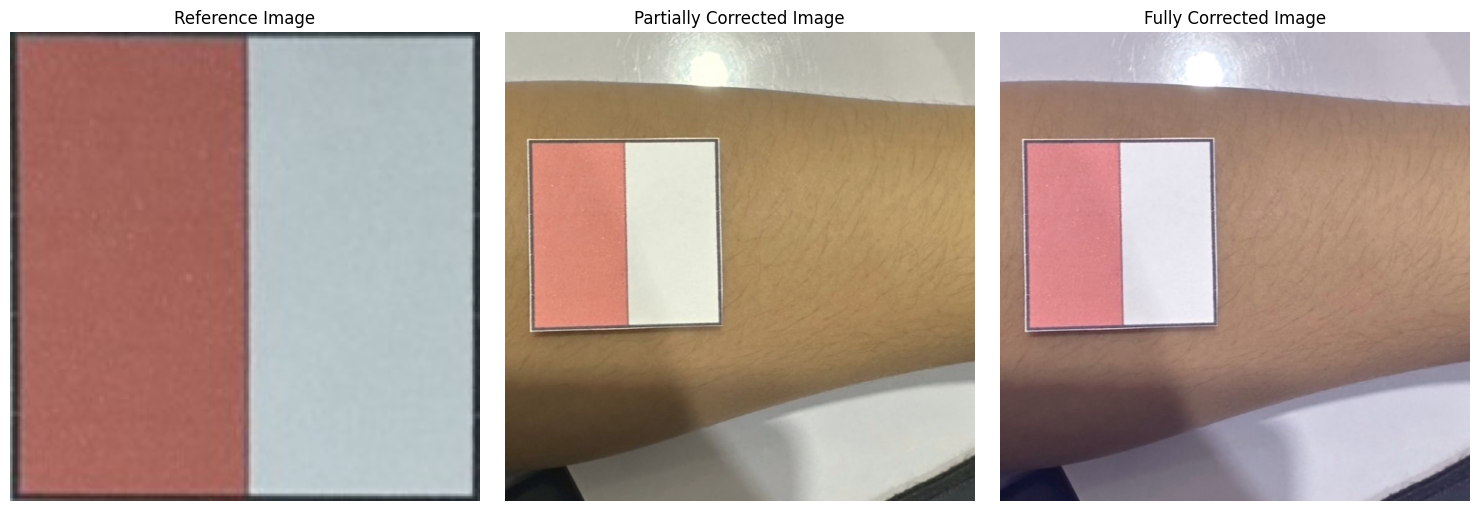

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_colors(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not loaded correctly.")
        return None, None

    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'Red': [(0, 100, 100), (10, 255, 255)],
        'Red2': [(160, 100, 100), (180, 255, 255)],
        'White': [(0, 0, 180), (180, 50, 255)]
    }

    combined_bbox = None
    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                x, y, w, h = cv2.boundingRect(cnt)
                if combined_bbox is None:
                    combined_bbox = (x, y, x + w, y + h)
                else:
                    combined_bbox = (
                        min(combined_bbox[0], x),
                        min(combined_bbox[1], y),
                        max(combined_bbox[2], x + w),
                        max(combined_bbox[3], y + h)
                    )

    if combined_bbox:
        x1, y1, x2, y2 = combined_bbox
        cropped_img = image[y1:y2, x1:x2]
        return cropped_img, (x1, y1, x2, y2)
    else:
        print("No valid colors detected!")
        return None, None

def adjust_brightness_contrast(reference_img, target_img):
    ref = reference_img.astype(np.float32) / 255.0
    target = target_img.astype(np.float32) / 255.0
    brightness_diff = np.mean(ref) - np.mean(target)
    contrast_diff = np.std(ref) - np.std(target)

    adjusted_target = target.copy()
    adjusted_target += brightness_diff
    adjusted_target = (adjusted_target - 0.001) * (1 + contrast_diff) + 0.001
    adjusted_target = np.clip(adjusted_target, 0, 1)

    return (adjusted_target * 255).astype(np.uint8), brightness_diff, contrast_diff

def adjust_tone(reference_img, target_img, step=0.0001):
    reference_img = reference_img.astype(np.float32) / 255.0
    target_img = target_img.astype(np.float32) / 255.0
    color_diff = np.mean(reference_img, axis=(0, 1)) - np.mean(target_img, axis=(0, 1))

    adjusted_target = target_img.copy()
    adjusted_target[:, :, 0] *= (1 + color_diff[0] * step)
    adjusted_target[:, :, 1] *= (1 + color_diff[1] * step)
    adjusted_target[:, :, 2] *= (1 + color_diff[2] * step)
    adjusted_target = np.clip(adjusted_target, 0, 1)

    return (adjusted_target * 255).astype(np.uint8), color_diff

def apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff):
    target_img = target_img.astype(np.float32) / 255.0
    target_img += brightness_diff
    target_img = (target_img - 0.5) * (1 + contrast_diff) + 0.5
    target_img[:, :, 0] += color_diff[0]
    target_img[:, :, 1] += color_diff[1]
    target_img[:, :, 2] += color_diff[2]
    target_img = np.clip(target_img, 0, 1)
    return (target_img * 255).astype(np.uint8)

def main():
    reference_img = cv2.imread('wtest2.jpg')
    target_img = cv2.imread('wtest7.jpg')

    cropped_img, bbox = detect_colors('wtest7.jpg')
    
    if cropped_img is None or bbox is None:
        return

    x1, y1, x2, y2 = bbox
    if reference_img is None or target_img is None:
        print("Error: Unable to load images")
        return

    cropped_img_resized = cv2.resize(cropped_img, (x2 - x1, y2 - y1))  # Resizing to match the crop size
    corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
    warm_corrected_img, color_diff = adjust_tone(reference_img, corrected_img, step=0.00001)

    threshold = 0.01
    prev_diff = float('inf')
    while True:

        corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
        warm_corrected_img, color_diff = adjust_tone(reference_img, corrected_img, step=0.00001)
        total_diff = np.abs(brightness_diff) + np.abs(contrast_diff) + np.sum(np.abs(color_diff))

        if total_diff < threshold or abs(total_diff - prev_diff) < threshold:
            break

        prev_diff = total_diff

    warm_corrected_img_resized = cv2.resize(warm_corrected_img, (x2 - x1, y2 - y1))
    full_img_corrected = apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff)

    target_img[y1:y2, x1:x2] = warm_corrected_img_resized

    reference_img_rgb = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    full_img_corrected_rgb = cv2.cvtColor(full_img_corrected, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(reference_img_rgb)
    axes[0].set_title("Reference Image")
    axes[0].axis("off")

    axes[1].imshow(img_rgb)
    axes[1].set_title("Partially Corrected Image")
    axes[1].axis("off")

    axes[2].imshow(full_img_corrected_rgb)
    axes[2].set_title("Fully Corrected Image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Average color of reference image (RGB): [140.20284986 142.45219899 166.95971557]
Average color of corrected image (RGB): [121.52915519 148.25078972 168.95537879]
Average color of warm corrected image (RGB): [122.52915519 147.25078972 167.95537879]
Total Brightness Adjustment: 0.09913313388824463
Total Contrast Adjustment: -0.04115906357765198
Total Color Difference: 0.006878165528178215
Total RGB Changes (R, G, B): [ 6380.808   -1956.767    -656.82416]


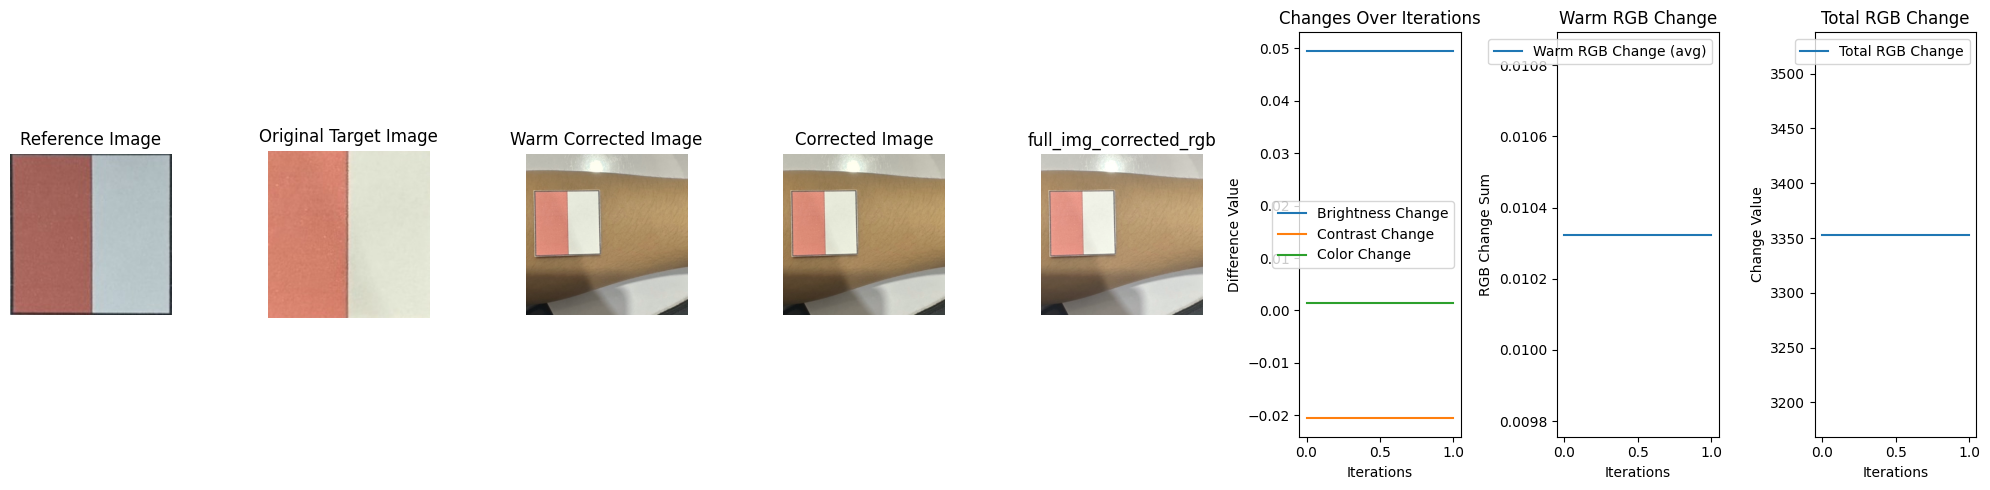

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_colors(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not loaded correctly.")
        return None, None

    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'Red': [(0, 100, 100), (10, 255, 255)],
        'Red2': [(160, 100, 100), (180, 255, 255)],
        'White': [(0, 0, 180), (180, 50, 255)]
    }

    combined_bbox = None
    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                x, y, w, h = cv2.boundingRect(cnt)
                if combined_bbox is None:
                    combined_bbox = (x, y, x + w, y + h)
                else:
                    combined_bbox = (
                        min(combined_bbox[0], x),
                        min(combined_bbox[1], y),
                        max(combined_bbox[2], x + w),
                        max(combined_bbox[3], y + h)
                    )

    if combined_bbox:
        x1, y1, x2, y2 = combined_bbox
        cropped_img = image[y1:y2, x1:x2]
        return cropped_img, (x1, y1, x2, y2)
    else:
        print("No valid colors detected!")
        return None, None

def adjust_brightness_contrast(reference_img, target_img):
    ref = reference_img.astype(np.float32) / 255.0
    target = target_img.astype(np.float32) / 255.0
    ref_avg_brightness = np.mean(ref)
    target_avg_brightness = np.mean(target)

    brightness_diff = ref_avg_brightness - target_avg_brightness
    contrast_diff = np.std(ref) - np.std(target)
    
    adjusted_target = target.copy()

    adjusted_target += brightness_diff
    adjusted_target = (adjusted_target - 0.001) * (1 + contrast_diff) + 0.001
    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    corrected_img = (adjusted_target * 255).astype(np.uint8)
    return corrected_img, brightness_diff, contrast_diff

def adjust_tone(reference_img, target_img, step=0.0001):
    reference_img = reference_img.astype(np.float32) / 255.0
    target_img = target_img.astype(np.float32) / 255.0
    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    target_avg_color = np.mean(target_img, axis=(0, 1))

    color_diff = ref_avg_color - target_avg_color

    # Scale the color difference to avoid overcorrection
    scale_factor = 0.1  # Adjust this as needed
    color_diff *= scale_factor

    adjusted_target = target_img.copy()
    adjusted_target += color_diff  # Directly add the difference

    # Track the change in each channel (RGB) per pixel
    rgb_changes = adjusted_target - target_img  # per-pixel RGB changes

    adjusted_target[:, :, 0] *= (1 + color_diff[0] * step)
    adjusted_target[:, :, 1] *= (1 + color_diff[1] * step)
    adjusted_target[:, :, 2] *= (1 + color_diff[2] * step)

    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    # Sum the total RGB changes for all pixels (per channel)
    total_rgb_changes = np.sum(rgb_changes, axis=(0, 1))  # Sum per channel (R, G, B)
    
    return (adjusted_target * 255).astype(np.uint8), color_diff, rgb_changes, total_rgb_changes

def calculate_color_difference(reference_img, corrected_img):
    color_diff = np.abs(reference_img.astype(np.float32) - corrected_img.astype(np.float32))
    return color_diff

def apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff):
    # แปลงภาพเป็น float32 เพื่อการคำนวณที่แม่นยำ
    target_img = target_img.astype(np.float32) / 255.0

    # ปรับค่าความสว่าง
    target_img += brightness_diff

    # ปรับคอนทราสต์
    target_img = (target_img - 0.5) * (1 + contrast_diff) + 0.5

    # ปรับโทนสี (R, G, B)
    target_img[:, :, 0] += color_diff[0]
    target_img[:, :, 1] += color_diff[1]
    target_img[:, :, 2] += color_diff[2]

    # คำนวณภาพสุดท้ายหลังการปรับ
    target_img = np.clip(target_img, 0, 1)

    # แปลงกลับเป็น uint8 และ return
    return (target_img * 255).astype(np.uint8)

# ในส่วนของฟังก์ชัน main
def main():
    reference_img = cv2.imread('wtest2.jpg')  # Reference image
    target_img = cv2.imread('cp1.jpg')  # Target image for analysis
    cropped_img, bbox = detect_colors('wtest7.jpg')

    target_img_as = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

    if cropped_img is None or bbox is None:
        return

    x1, y1, x2, y2 = bbox
    if reference_img is None or target_img is None:
        print("Error: Unable to load images")
        return

    target_img = cv2.resize(target_img, (reference_img.shape[1], reference_img.shape[0]))

    previous_avg_diff = np.inf  # Start with the highest possible difference
    tolerance = 0.01  # Acceptable difference tolerance

    # Track changes in brightness, contrast, color, and warm color
    brightness_changes = []
    contrast_changes = []
    color_changes = []
    warm_color_changes = []  # Track RGB changes for warm adjustment
    total_rgb_changes_overall = []  # Track total RGB changes for each iteration

    total_brightness_change = 0
    total_contrast_change = 0
    total_color_change = 0

    cropped_img_resized = cv2.resize(cropped_img, (x2 - x1, y2 - y1))  # Resizing to match the crop size
    corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
    warm_corrected_img, color_diff ,warm_rgb_changes, total_rgb_changes = adjust_tone(reference_img, corrected_img, step=0.00001)

    threshold = 0.01
    prev_diff = float('inf')

    while True:
        corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
        warm_corrected_img, color_diff ,warm_rgb_changes, total_rgb_changes = adjust_tone(reference_img, corrected_img, step=0.00001)
        total_diff = np.abs(brightness_diff) + np.abs(contrast_diff) + np.sum(np.abs(color_diff))

        # Collect the changes
        brightness_changes.append(brightness_diff)
        contrast_changes.append(contrast_diff)
        color_changes.append(color_diff)
        warm_color_changes.append(np.mean(np.abs(warm_rgb_changes), axis=(0, 1)))  # Track average RGB change for warm
        total_rgb_changes_overall.append(total_rgb_changes)  # Track total RGB changes

        total_brightness_change += brightness_diff
        total_contrast_change += contrast_diff
        total_color_change += np.mean(np.abs(color_diff))  # Average color difference

        corrected_avg_color = np.mean(corrected_img, axis=(0, 1))
        warm_corrected_avg_color = np.mean(warm_corrected_img, axis=(0, 1))
        current_avg_diff = np.abs(np.mean(reference_img, axis=(0, 1)) - corrected_avg_color).sum()

        if current_avg_diff < tolerance:
            break
        target_img = warm_corrected_img

        if abs(previous_avg_diff - current_avg_diff) < tolerance:
            break
        previous_avg_diff = current_avg_diff
        
        if total_diff < threshold or abs(total_diff - prev_diff) < threshold:
            break
        prev_diff = total_diff


    warm_corrected_img_resized = cv2.resize(warm_corrected_img, (x2 - x1, y2 - y1))
    full_img_corrected = apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff)

    target_img[y1:y2, x1:x2] = warm_corrected_img_resized

    # Show results
    reference_img_rgb = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    target_img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    corrected_img_rgb = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB)
    warm_corrected_img_rgb = cv2.cvtColor(warm_corrected_img, cv2.COLOR_BGR2RGB)

    full_img_corrected_rgb = cv2.cvtColor(full_img_corrected, cv2.COLOR_BGR2RGB)
    
    # Plot the changes
    fig, axes = plt.subplots(1, 8, figsize=(20, 5))  # Increase the number of columns to 8
    axes[0].imshow(reference_img_rgb)
    axes[0].set_title("Reference Image")
    axes[0].axis("off")

    axes[1].imshow(target_img_as)
    axes[1].set_title("Original Target Image")
    axes[1].axis("off")

    axes[2].imshow(warm_corrected_img_rgb)
    axes[2].set_title("Warm Corrected Image")
    axes[2].axis("off")

    axes[3].imshow(corrected_img_rgb)
    axes[3].set_title("Corrected Image")
    axes[3].axis("off")

    axes[4].imshow(full_img_corrected_rgb)
    axes[4].set_title("full_img_corrected_rgb")
    axes[4].axis("off")

    # Plotting the changes
    axes[5].plot(brightness_changes, label="Brightness Change")
    axes[5].plot(contrast_changes, label="Contrast Change")
    axes[5].plot([np.mean(diff) for diff in color_changes], label="Color Change")
    axes[5].set_title("Changes Over Iterations")
    axes[5].set_xlabel("Iterations")
    axes[5].set_ylabel("Difference Value")
    axes[5].legend()

    axes[6].plot([change.sum() for change in warm_color_changes], label="Warm RGB Change (avg)")
    axes[6].set_title("Warm RGB Change")
    axes[6].set_xlabel("Iterations")
    axes[6].set_ylabel("RGB Change Sum")
    axes[6].legend()

    # Plot the total RGB changes per iteration
    axes[7].plot([np.linalg.norm(change) for change in total_rgb_changes_overall], label="Total RGB Change")
    axes[7].set_title("Total RGB Change")
    axes[7].set_xlabel("Iterations")
    axes[7].set_ylabel("Change Value")
    axes[7].legend()

    # Print average colors
    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    corrected_avg_color = np.mean(corrected_img, axis=(0, 1))
    warm_corrected_avg_color = np.mean(warm_corrected_img, axis=(0, 1))

    print(f"Average color of reference image (RGB): {ref_avg_color}")
    print(f"Average color of corrected image (RGB): {corrected_avg_color}")
    print(f"Average color of warm corrected image (RGB): {warm_corrected_avg_color}")

    # Display total changes
    print(f"Total Brightness Adjustment: {total_brightness_change}")
    print(f"Total Contrast Adjustment: {total_contrast_change}")
    print(f"Total Color Difference: {total_color_change}")
    
    # Print total RGB changes (summed for all iterations)
    total_rgb_change = np.sum(total_rgb_changes_overall, axis=0)  # Sum total RGB changes
    print(f"Total RGB Changes (R, G, B): {total_rgb_change}")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

Total Brightness Adjustment: 0.09913313388824463
Total Contrast Adjustment: -0.04115906357765198
Total Color Difference: 0.1538843274888039
Total RGB Changes (R, G, B): [ 37.34184265 -11.42778039  -3.8483423 ]


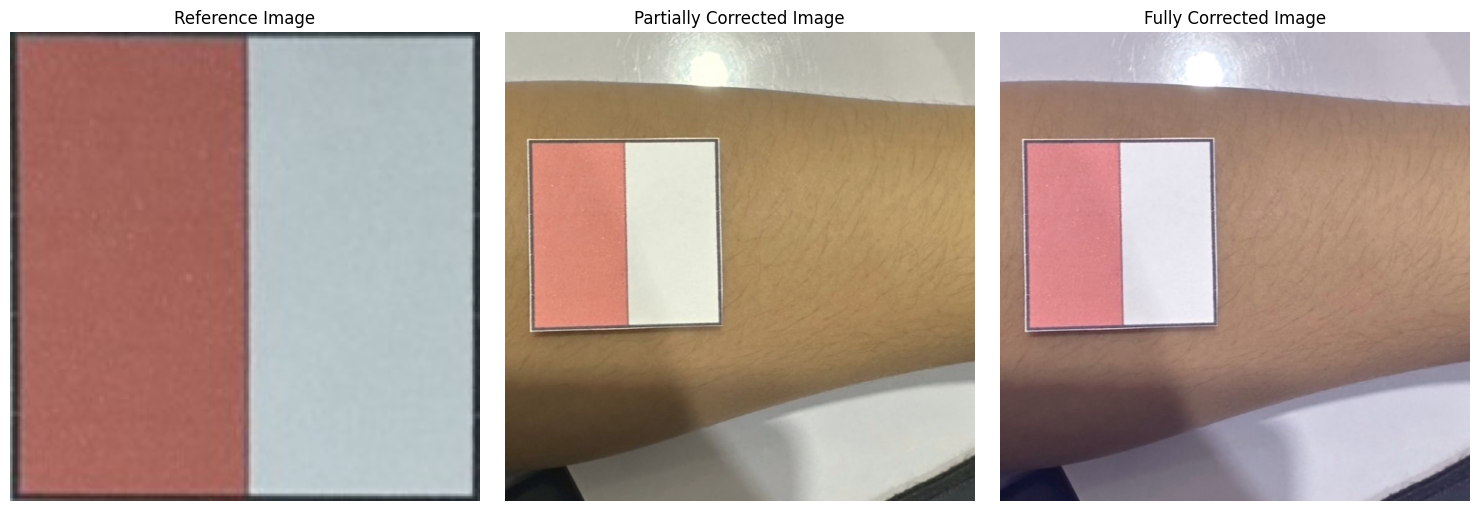

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_colors(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not loaded correctly.")
        return None, None

    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'Red': [(0, 100, 100), (10, 255, 255)],
        'Red2': [(160, 100, 100), (180, 255, 255)],
        'White': [(0, 0, 150), (180, 50, 255)]
    }

    combined_bbox = None
    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                x, y, w, h = cv2.boundingRect(cnt)
                if combined_bbox is None:
                    combined_bbox = (x, y, x + w, y + h)
                else:
                    combined_bbox = (
                        min(combined_bbox[0], x),
                        min(combined_bbox[1], y),
                        max(combined_bbox[2], x + w),
                        max(combined_bbox[3], y + h)
                    )

    if combined_bbox:
        x1, y1, x2, y2 = combined_bbox
        cropped_img = image[y1:y2, x1:x2]
        return cropped_img, (x1, y1, x2, y2)
    else:
        print("No valid colors detected!")
        return None, None

def adjust_brightness_contrast(reference_img, target_img):
    ref = reference_img.astype(np.float32) / 255.0
    target = target_img.astype(np.float32) / 255.0
    brightness_diff = np.mean(ref) - np.mean(target)
    contrast_diff = np.std(ref) - np.std(target)
    
    adjusted_target = target.copy()
    adjusted_target += brightness_diff
    adjusted_target = (adjusted_target - 0.001) * (1 + contrast_diff) + 0.001
    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    return (adjusted_target * 255).astype(np.uint8), brightness_diff, contrast_diff

def adjust_tone(reference_img, target_img, step=0.0001):
    reference_img = reference_img.astype(np.float32) / 255.0
    target_img = target_img.astype(np.float32) / 255.0
    color_diff = np.mean(reference_img, axis=(0, 1)) - np.mean(target_img, axis=(0, 1))
    
    adjusted_target = target_img.copy()
    adjusted_target[:, :, 0] *= (1 + color_diff[0] * step)
    adjusted_target[:, :, 1] *= (1 + color_diff[1] * step)
    adjusted_target[:, :, 2] *= (1 + color_diff[2] * step)
    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    return (adjusted_target * 255).astype(np.uint8), color_diff

def apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff):
    target_img = target_img.astype(np.float32) / 255.0
    target_img += brightness_diff
    target_img = (target_img - 0.5) * (1 + contrast_diff) + 0.5
    target_img[:, :, 0] += color_diff[0]
    target_img[:, :, 1] += color_diff[1]
    target_img[:, :, 2] += color_diff[2]
    target_img = np.clip(target_img, 0, 1)
    return (target_img * 255).astype(np.uint8)

def main():
    reference_img = cv2.imread('wtest2.jpg')
    target_img = cv2.imread('wtest7.jpg')

    cropped_img, bbox = detect_colors('wtest7.jpg')
    if cropped_img is None or bbox is None:
        return
    
    x1, y1, x2, y2 = bbox
    cropped_img_resized = cv2.resize(cropped_img, (x2 - x1, y2 - y1))

    total_brightness_diff = 0
    total_contrast_diff = 0
    total_color_diff = np.array([0.0, 0.0, 0.0])
    
    threshold = 0.01
    prev_diff = float('inf')
    while True:
        corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, cropped_img_resized)
        warm_corrected_img, color_diff = adjust_tone(reference_img, corrected_img, step=0.00001)
        total_diff = abs(brightness_diff) + abs(contrast_diff) + np.sum(abs(color_diff))
        
        total_brightness_diff += brightness_diff
        total_contrast_diff += contrast_diff
        total_color_diff += color_diff
        
        if total_diff < threshold or abs(total_diff - prev_diff) < threshold:
            break
        prev_diff = total_diff
    
    warm_corrected_img_resized = cv2.resize(warm_corrected_img, (x2 - x1, y2 - y1))
    full_img_corrected = apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff)

    target_img[y1:y2, x1:x2] = warm_corrected_img_resized

    reference_img_rgb = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    full_img_corrected_rgb = cv2.cvtColor(full_img_corrected, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(reference_img_rgb)
    axes[0].set_title("Reference Image")
    axes[0].axis("off")

    axes[1].imshow(img_rgb)
    axes[1].set_title("Partially Corrected Image")
    axes[1].axis("off")

    axes[2].imshow(full_img_corrected_rgb)
    axes[2].set_title("Fully Corrected Image")
    axes[2].axis("off")

    print(f"Total Brightness Adjustment: {total_brightness_diff}")
    print(f"Total Contrast Adjustment: {total_contrast_diff}")
    print(f"Total Color Difference: {np.linalg.norm(total_color_diff)}")
    print(f"Total RGB Changes (R, G, B): {total_color_diff * 255}")
    
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    main()


Pixels matching Red: 0
Pixels matching Red2: 0
Pixels matching White: 33889
Detected Color Positions:
White: (318, 104, 29, 51)
White: (131, 47, 135, 257)
Combined Bounding Box: (131, 47, 347, 304)
Average color of reference image (RGB): [140.20284986 142.45219899 166.95971557]
Average color of corrected image (RGB): [139.29212508 142.21877887 166.6111811 ]
Average color of warm corrected image (RGB): [139.29212508 142.21877887 166.6111811 ]
Total Brightness Adjustment: 0.0032197237014770508
Total Contrast Adjustment: -0.04544930160045624
Total Color Difference: 0.03635716295684688


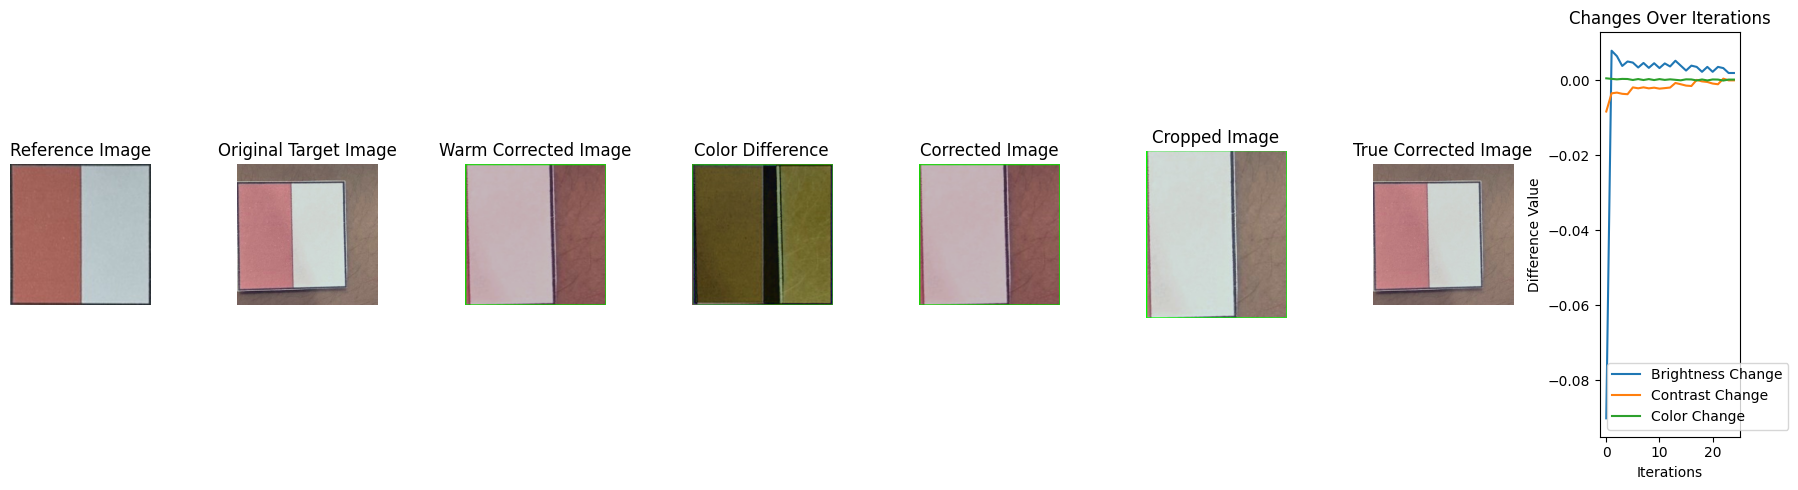

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_colors(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not loaded correctly.")
        return

    # ลด noise ก่อนแปลงภาพ
    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'Red': [(0, 100, 100), (10, 255, 255)],  
        'Red2': [(160, 100, 100), (180, 255, 255)],  
        'White': [(0, 0, 150), (180, 80, 255)]  # ปรับช่วงของสีขาว
    }


    color_positions = []
    combined_bbox = None

    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)

        # ลองเพิ่มการ Morphological Transform เพื่อลบ noise ออกจาก mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        matching_pixels = np.sum(mask > 0)
        print(f"Pixels matching {color}: {matching_pixels}")

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            if cv2.contourArea(cnt) > 500:  # ลดเงื่อนไขลงเพื่อให้หาเจอง่ายขึ้น
                x, y, w, h = cv2.boundingRect(cnt)
                color_positions.append((color, x, y, w, h))

                if combined_bbox is None:
                    combined_bbox = (x, y, x + w, y + h)
                else:
                    combined_bbox = (
                        min(combined_bbox[0], x),
                        min(combined_bbox[1], y),
                        max(combined_bbox[2], x + w),
                        max(combined_bbox[3], y + h)
                    )

    print("Detected Color Positions:")
    for color, x, y, w, h in color_positions:
        print(f"{color}: {(x, y, w, h)}")

    if combined_bbox:
        cv2.rectangle(image, (combined_bbox[0], combined_bbox[1]), (combined_bbox[2], combined_bbox[3]), (0, 255, 0), 2)
        print(f"Combined Bounding Box: {combined_bbox}")
        cropped_img = image[combined_bbox[1]:combined_bbox[3], combined_bbox[0]:combined_bbox[2]]
        
        # Convert cropped image to RGB
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        return cropped_img_rgb  # Return cropped image for further use
    else:
        print("No valid colors detected!")
        return None

def adjust_brightness_contrast(reference_img, target_img):
    ref = reference_img.astype(np.float32) / 255.0
    target = target_img.astype(np.float32) / 255.0
    ref_avg_brightness = np.mean(ref)
    target_avg_brightness = np.mean(target)

    brightness_diff = ref_avg_brightness - target_avg_brightness
    contrast_diff = np.std(ref) - np.std(target)
    
    adjusted_target = target.copy()

    adjusted_target += brightness_diff
    adjusted_target = (adjusted_target - 0.00001) * (1 + contrast_diff) + 0.001
    adjusted_target = np.clip(adjusted_target, 0, 1)
    
    corrected_img = (adjusted_target * 255).astype(np.uint8)
    return corrected_img, brightness_diff, contrast_diff

def adjust_tone(reference_img, target_img, step=0.000001):
    reference_img = reference_img.astype(np.float32) / 255.0
    target_img = target_img.astype(np.float32) / 255.0
    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    target_avg_color = np.mean(target_img, axis=(0, 1))

    color_diff = ref_avg_color - target_avg_color

    # Scale the color difference to avoid overcorrection
    scale_factor = 0.1  # Adjust this as needed
    color_diff *= scale_factor

    adjusted_target = target_img.copy()
    adjusted_target += color_diff  # Directly add the difference

    adjusted_target[:, :, 0] *= (1 + color_diff[0] * step)
    adjusted_target[:, :, 1] *= (1 + color_diff[1] * step)
    adjusted_target[:, :, 2] *= (1 + color_diff[2] * step)

    adjusted_target = np.clip(adjusted_target, 0, 1)
    return (adjusted_target * 255).astype(np.uint8), color_diff

def calculate_color_difference(reference_img, corrected_img):
    color_diff = np.abs(reference_img.astype(np.float32) - corrected_img.astype(np.float32))
    return color_diff

def apply_adjustments(target_img, brightness_diff, contrast_diff, color_diff):
    # แปลงภาพเป็น float32 เพื่อการคำนวณที่แม่นยำ
    target_img = target_img.astype(np.float32) / 255.0

    # ปรับค่าความสว่าง
    target_img += brightness_diff

    # ปรับคอนทราสต์
    target_img = (target_img - 0.5) * (1 + contrast_diff) + 0.5

    # ปรับโทนสี (R, G, B)
    target_img[:, :, 0] += color_diff[0]
    target_img[:, :, 1] += color_diff[1]
    target_img[:, :, 2] += color_diff[2]

    # คำนวณภาพสุดท้ายหลังการปรับ
    target_img = np.clip(target_img, 0, 1)

    # แปลงกลับเป็น uint8 และ return
    return (target_img * 255).astype(np.uint8)

def main():
    reference_img = cv2.imread('wtest2.jpg')  # ภาพต้นฉบับ
    target_img = cv2.imread('wtest4.jpg')  # ภาพที่ต้องการวิเคราะห์

    cropped_img_rgb = detect_colors("wtest4.jpg")  # Get cropped RGB image from color detection

    if reference_img is None or target_img is None or cropped_img_rgb is None:
        print("Error: ไม่สามารถโหลดภาพได้")
        return

    target_img_ts = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cropped_img_rgb, cv2.COLOR_BGR2RGB)
    target_img_as = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

    target_img = cv2.resize(target_img, (reference_img.shape[1], reference_img.shape[0]))

    adjusted_img = cv2.imread('wtest4.jpg')

    previous_avg_diff = np.inf  # Start with the highest possible difference
    tolerance = 0.01  # Acceptable difference tolerance

    brightness_changes = []
    contrast_changes = []
    color_changes = []

    total_brightness_change = 0
    total_contrast_change = 0
    total_color_change = 0

    while True:
        corrected_img, brightness_diff, contrast_diff = adjust_brightness_contrast(reference_img, target_img)
        warm_corrected_img, color_diff = adjust_tone(reference_img, corrected_img, step=0.000001)

        brightness_changes.append(brightness_diff)
        contrast_changes.append(contrast_diff)
        color_changes.append(color_diff)

        total_brightness_change += brightness_diff
        total_contrast_change += contrast_diff
        total_color_change += np.mean(np.abs(color_diff))  # Average color difference

        corrected_avg_color = np.mean(corrected_img, axis=(0, 1))
        warm_corrected_avg_color = np.mean(warm_corrected_img, axis=(0, 1))
        current_avg_diff = np.abs(np.mean(reference_img, axis=(0, 1)) - corrected_avg_color).sum()

        if current_avg_diff < tolerance:
            break

        target_img = warm_corrected_img

        if abs(previous_avg_diff - current_avg_diff) < tolerance:
            break
        previous_avg_diff = current_avg_diff

    color_diff_result = calculate_color_difference(reference_img, corrected_img)
    
    reference_img_rgb = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    target_img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    corrected_img_rgb = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB)
    warm_corrected_img_rgb = cv2.cvtColor(warm_corrected_img, cv2.COLOR_BGR2RGB)
    color_diff_rgb = np.clip(color_diff_result, 0, 255).astype(np.uint8)

    # ใช้ apply_adjustments สำหรับการปรับภาพใหม่
    true_corrected_img = apply_adjustments(
        adjusted_img, 
        total_brightness_change, 
        total_contrast_change, 
        np.array([total_color_change] * 3)  # ใช้ค่าเฉลี่ยของ total_color_change สำหรับ RGB
    )
    
    true_corrected_img_rgb = cv2.cvtColor(true_corrected_img, cv2.COLOR_BGR2RGB)
    
    # ปรับ true_corrected_img_rgb ให้มีสีเหมือน corrected_img_rgb
    corrected_avg_color = np.mean(corrected_img_rgb, axis=(0, 1))
    true_corrected_avg_color = np.mean(true_corrected_img_rgb, axis=(0, 1))
    color_adjustment = corrected_avg_color - true_corrected_avg_color

    adjusted_true_corrected_img = true_corrected_img_rgb.astype(np.float32) + color_adjustment
    adjusted_true_corrected_img = np.clip(adjusted_true_corrected_img, 0, 255).astype(np.uint8)
    true_corrected_img_rgb = adjusted_true_corrected_img
    
    fig, axes = plt.subplots(1, 8, figsize=(18, 5))
    axes[0].imshow(reference_img_rgb)
    axes[0].set_title("Reference Image")
    axes[0].axis("off")
    
    axes[1].imshow(target_img_ts)
    axes[1].set_title("Original Target Image")
    axes[1].axis("off")
    
    axes[2].imshow(warm_corrected_img_rgb)
    axes[2].set_title("Warm Corrected Image")
    axes[2].axis("off")
    
    axes[3].imshow(color_diff_rgb)
    axes[3].set_title("Color Difference")
    axes[3].axis("off")
    
    axes[4].imshow(corrected_img_rgb)
    axes[4].set_title("Corrected Image")
    axes[4].axis("off")
    
    axes[5].imshow(cropped_img_rgb)
    axes[5].set_title("Cropped Image")
    axes[5].axis("off")

    axes[6].imshow(true_corrected_img_rgb)
    axes[6].set_title("True Corrected Image")
    axes[6].axis("off")

    axes[7].plot(brightness_changes, label="Brightness Change")
    axes[7].plot(contrast_changes, label="Contrast Change")
    axes[7].plot([np.mean(diff) for diff in color_changes], label="Color Change")
    axes[7].set_title("Changes Over Iterations")
    axes[7].set_xlabel("Iterations")
    axes[7].set_ylabel("Difference Value")
    axes[7].legend()

    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    corrected_avg_color = np.mean(corrected_img, axis=(0, 1))
    warm_corrected_avg_color = np.mean(warm_corrected_img, axis=(0, 1))

    print(f"Average color of reference image (RGB): {ref_avg_color}")
    print(f"Average color of corrected image (RGB): {corrected_avg_color}")
    print(f"Average color of warm corrected image (RGB): {warm_corrected_avg_color}")
    
    print(f"Total Brightness Adjustment: {total_brightness_change}")
    print(f"Total Contrast Adjustment: {total_contrast_change}")
    print(f"Total Color Difference: {total_color_change}")
    
    cv2.imwrite("true_corrected_img_rgb1.jpg", cv2.cvtColor(true_corrected_img_rgb, cv2.COLOR_RGB2BGR))
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
Pixels matching Red: 31733
Pixels matching Red2: 0
Pixels matching White: 32785
Detected Color Positions:
Red: (7, 51, 131, 254)
White: (133, 47, 138, 257)
Combined Bounding Box: (7, 47, 271, 305)
Average color of reference image (RGB): [140.20284986 142.45219899 166.95971557]
Average color of corrected image (RGB): [138.95753198 142.1574424  166.55356793]
Average color of warm corrected image (RGB): [138.95753198 142.1574424  166.55356793]
Total Brightness Adjustment: -0.05894017219543457
Total Contrast Adjustment: 0.050554826855659485
Total Color Difference: 0.045340095210121945

In [ ]:
from flask import Flask, request, render_template, send_file
import cv2
import numpy as np
import os
from werkzeug.utils import secure_filename
import matplotlib.pyplot as plt

app = Flask(__name__)
UPLOAD_FOLDER = 'uploads'
RESULT_FOLDER = 'results'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
os.makedirs(RESULT_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['RESULT_FOLDER'] = RESULT_FOLDER

def detect_colors(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None, "Image not loaded correctly."

    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

    color_ranges = {
        'Red': [(0, 100, 100), (10, 255, 255)],  
        'Red2': [(160, 100, 100), (180, 255, 255)],  
        'White': [(0, 0, 150), (180, 80, 255)]
    }

    combined_bbox = None

    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)

        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                x, y, w, h = cv2.boundingRect(cnt)
                if combined_bbox is None:
                    combined_bbox = (x, y, x + w, y + h)
                else:
                    combined_bbox = (
                        min(combined_bbox[0], x),
                        min(combined_bbox[1], y),
                        max(combined_bbox[2], x + w),
                        max(combined_bbox[3], y + h)
                    )

    if combined_bbox:
        cropped_img = image[combined_bbox[1]:combined_bbox[3], combined_bbox[0]:combined_bbox[2]]
        return cropped_img, None
    else:
        return None, "No valid colors detected!"


def process_image(image_path, reference_path):
    reference_img = cv2.imread(reference_path)
    target_img = cv2.imread(image_path)
    cropped_img, error = detect_colors(image_path)

    if reference_img is None or target_img is None or cropped_img is None:
        return None, "Error: Cannot load images."

    reference_img = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

    ref_avg_color = np.mean(reference_img, axis=(0, 1))
    target_avg_color = np.mean(cropped_img, axis=(0, 1))
    color_diff = ref_avg_color - target_avg_color
    
    corrected_img = cropped_img.astype(np.float32) + color_diff
    corrected_img = np.clip(corrected_img, 0, 255).astype(np.uint8)
    corrected_img = cv2.cvtColor(corrected_img, cv2.COLOR_RGB2BGR)
    
    result_path = os.path.join(RESULT_FOLDER, 'corrected_image.jpg')
    cv2.imwrite(result_path, corrected_img)
    
    return result_path, None


@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        if 'file' not in request.files or 'reference' not in request.files:
            return 'No file part'
        
        file = request.files['file']
        reference = request.files['reference']

        if file.filename == '' or reference.filename == '':
            return 'No selected file'

        filename = secure_filename(file.filename)
        reference_filename = secure_filename(reference.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        reference_path = os.path.join(app.config['UPLOAD_FOLDER'], reference_filename)

        file.save(file_path)
        reference.save(reference_path)

        result_path, error = process_image(file_path, reference_path)

        if error:
            return error

        return render_template('result.html', result_image=result_path)
    
    return render_template('upload.html')


@app.route('/download')
def download_file():
    result_path = os.path.join(RESULT_FOLDER, 'corrected_image.jpg')
    return send_file(result_path, as_attachment=True)


if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
